## Pacotes

In [70]:
import pandas as pd
import os
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
import seaborn as sns
import re
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
import random

# Diretório


In [73]:
diretorio = r'C:\Users\JoãoPinheiro\OneDrive - CTI Global\Área de Trabalho\dados_reviews'
diretorio = diretorio.replace('\\','/')
os.chdir(diretorio)


'C:\\Users\\JoãoPinheiro\\OneDrive - CTI Global\\Área de Trabalho\\dados_reviews'

# Conjunto de dados
https://www.kaggle.com/datasets/andrewmvd/steam-reviews


In [74]:
dados = pd.read_csv('dataset.csv')


# Renomeação de colunas
O score 1 indica que o jogo é recomendável e o score 0 indica que o jogo não é recomendável.

In [77]:
dados = dados[['app_name','review_text','review_score']]
dados.columns = ['nome','avaliacao_texto','score']


In [ ]:
dados['avaliacao_texto'] = dados['avaliacao_texto'].astype('string')


,nome,avaliacao_texto,score
0,Counter-Strike,Ruined my life.,1
1,Counter-Strike,This will be more of a ''my experience with th...,1
2,Counter-Strike,This game saved my virginity.,1
3,Counter-Strike,• Do you like original games? • Do you like ga...,1
4,Counter-Strike,"Easy to learn, hard to master.",1


## Tratamento dos dados


In [78]:
# Retirada pontuacao
def retirar_pontuacao(texto):
    return re.sub(r'[^\w\s]','', texto)

dados['avaliacao_new'] = dados['avaliacao_texto'].apply(func = retirar_pontuacao)

# Retirada de 'stopwords'
stopwords = set(nltk.corpus.stopwords.words('english'))
def retirar_stopwords(linha):
    palavra_limpa = [i for i in linha.split() if i.lower() not in stopwords] # aqui resulta em uma nova lista # [expressao for item in iterable if condicao]
    return ' '.join(palavra_limpa) # aqui as palavras sao separadas por espaço em branco

dados['avaliacao_new'] = dados['avaliacao_new'].apply(func = retirar_stopwords) 
# usar para validar:
# linha de index 2 , ver que o 'you' em 'avaliacao_texto' foi retirado na coluna 'avaliacao_new'
# linha de index 5 , ver que o 'the' em 'avaliacao_texto' foi retirado na coluna 'avaliacao_new'
# linha de index 8 , ver que o 'an' em 'avaliacao_texto' foi retirado na coluna 'avaliacao_new'



TypeError: expected string or bytes-like object, got 'float'

In [ ]:
# Stemming
nltk.download('punkt')
stemmer = PorterStemmer()

def stemming(frase):
    palavra_token = word_tokenize(frase) # tokenização, ou seja, faz a quebra os caracteres
    palavra_stemming = [stemmer.stem(i) for i in palavra_token] # faz o stemming em cada palavra
    return ' '.join(palavra_stemming)

dados['avaliacao_new'] = dados['avaliacao_new'].apply(func = stemming)


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\JoãoPinheiro\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## Vetorização
Cada linha da tabela 'tfidf_tabela' representa uma avaliação e cada coluna representa uma palavra.

Aqui serão gerados os pesos de cada palavra em cada review.

In [ ]:
vetor = TfidfVectorizer()
tfidf = vetor.fit_transform(dados['avaliacao_new']) # o tfidf será usado no Naive-Bayes
palavras = vetor.get_feature_names_out()
tfidf_tabela = pd.DataFrame(tfidf.toarray(), columns = palavras)


## Palavras mais frequentes
São as palavras com maior peso.


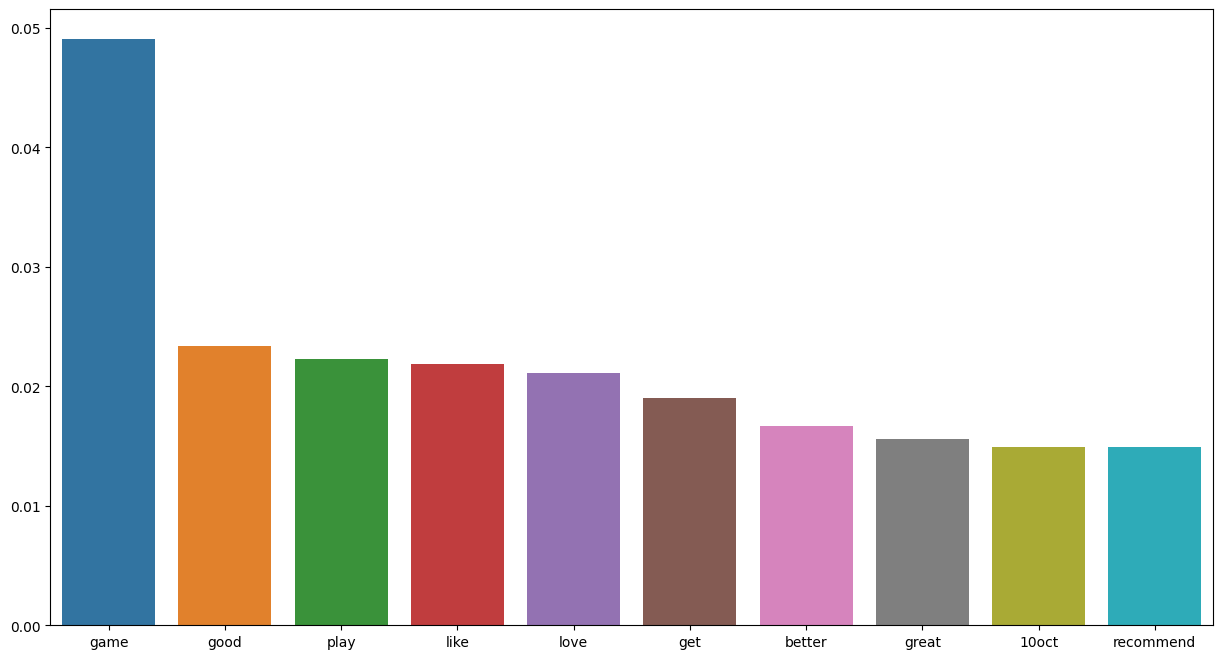

In [60]:
# Média de cada coluna e filtrando alguma quantidade de  palavras com maior média dos pesos em cada review
mean = tfidf_tabela.mean(axis=0)

def mean_top (numero):
    mean_top = pd.DataFrame(round(mean.nlargest(numero),4), columns=['mean']).T
    return sns.barplot(data = mean_top).figure.set_size_inches(15,8)

# modificar número
mean_top(10)


# K-means
Precisa-se chegar a um número ideal de clusters, plotar gráfico, analisar SSE.

In [61]:
# Clusters (K-means) - método não-supervisionado
k = 10
kmeans = KMeans(n_clusters=k, random_state=111)
kmeans.fit(tfidf_tabela)
labels = kmeans.labels_
dados['etiquetas_cluster'] = labels


c:\Users\JoãoPinheiro\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


# Naive Bayes Bernoulli
Indicado para casos em que a variável dependente é binária. Nesse caso a variável 'score' é 1 ou 0.

In [ ]:
# Base treino (80%) e teste (20%)
y = dados['score']

treino_x, teste_x, treino_y, teste_y = train_test_split(tfidf, y, test_size=0.2, random_state=111, stratify=y)

In [ ]:
naive_bayes = MultinomialNB()
naive_bayes.fit(treino_x, treino_y)
predicts = naive_bayes.predict(teste_x)

acuracia = accuracy_score(teste_y, predicts)
print('Acurácia: ',acuracia)

relatorio = classification_report(teste_y, predicts)
print(relatorio)

Acurácia:  0.10721868365180467
              precision    recall  f1-score   support

           1       0.11      0.10      0.10       102
           2       0.12      0.14      0.12       103
           3       0.07      0.10      0.08       109
           4       0.11      0.08      0.10       110
           5       0.10      0.07      0.08        99
           6       0.11      0.09      0.10       103
           7       0.10      0.10      0.10       105
           8       0.13      0.20      0.15       111
           9       0.15      0.09      0.11       100

    accuracy                           0.11       942
   macro avg       0.11      0.11      0.11       942
weighted avg       0.11      0.11      0.11       942

